# TODO
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another, create_icon_from_slide_general_path
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v010_hsk2_v1 import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [ ]:
truly_load_data = False
to_delete = False

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'hsk2_v1',
 'different_file_name': 'static/hsk/HSK2_sent_cat.csv',
 'custom_filters': [{'col_name': 'index', 'val': 0, 'operator_str': '>='},
  {'col_name': 'index', 'val': 999, 'operator_str': '<='}],
 'sort_keys': ['category', 'index'],
 'sort_asc': [True, True],
 'voice_name_zh': 'zh-CN-XiaoyuMultilingualNeural',
 'voice_name_en': 'en-US-AvaMultilingualNeural',
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_combo_quality': 6,
 'categories_allowed': None,
 'categories2_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_str

# 1. Load data

In [6]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

1001_ec_csent_hsk2_v1 736


,index,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,trad,hsk3.0_pinyin,hsk3.0_def,video_notes,category
0,17,比如,bǐ rú,such as,中国有很多美食比如饺子,zhōng guó yǒu hěn duō měi shí bǐ rú jiǎo zi,China has many delicious foods such as dumplings,比如,bǐrú,"for example, for instance, such as","HSK3.0 definition: for example, for instance, ...",Society & Communication
1,607,信,xìn,letter,我收到了一封信。,wǒ shōu dào le yī fēng xìn.,I received a letter.,信,xìn,"letter, mail, message","HSK3.0 definition: letter, mail, message",Society & Communication
2,6,办,bàn,to handle,我去办护照,wǒ qù bàn hù zhào,I am going to handle my passport,辦,bàn,"punish (by law), manage, get ... ready, set_up...","HSK3.0 definition: punish (by law), manage, ge...",Actions & Verbs


# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 比如
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, such as
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 中国有很多美食比如饺子
0.0s, row1
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 信
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, letter
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 我收到了一封信。
0.0s, row2
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 办
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, to handle
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 我去办护照
0.0s, row3
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 办法
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, method
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 这个问题有办法解决
0.0s, row4
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 帮助
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, to help
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 谢谢你帮助我学习
0.0s, row5
0.000s, AL

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.32 seconds, recid1001_ec_csent_hsk2_v1, row 0, 比如
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 1, 信
0.28 seconds, recid1001_ec_csent_hsk2_v1, row 2, 办
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 3, 办法
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 4, 帮助
0.36 seconds, recid1001_ec_csent_hsk2_v1, row 5, 报名
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 6, 背
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 7, 变
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 8, 必须
0.29 seconds, recid1001_ec_csent_hsk2_v1, row 9, 变成
0.31 seconds, recid1001_ec_csent_hsk2_v1, row 10, 不要
0.31 seconds, recid1001_ec_csent_hsk2_v1, row 11, 参观
0.32 seconds, recid1001_ec_csent_hsk2_v1, row 12, 参加
0.32 seconds, recid1001_ec_csent_hsk2_v1, row 13, 查
0.32 seconds, recid1001_ec_csent_hsk2_v1, row 14, 称
0.42 seconds, recid1001_ec_csent_hsk2_v1, row 15, 重复
0.33 seconds, recid1001_ec_csent_hsk2_v1, row 16, 出发
0.32 seconds, recid1001_ec_csent_hsk2_v1, row 17, 成为
0.31 seconds, recid1001_ec_csent_hsk2_v1, row 18, 出国
0.32 seco

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,比如,bǐ rú,such as,中国有很多美食比如饺子,zhōng guó yǒu hěn duō měi shí bǐ rú jiǎo zi,China has many delicious foods such as dumplings,1.272,0.984,2.808,0,1.772,3.256,7.064,7.063667,"HSK3.0 definition: for example, for instance, ...",None,None,None
1,信,xìn,letter,我收到了一封信。,wǒ shōu dào le yī fēng xìn.,I received a letter.,0.888,0.936,1.752,0,1.388,2.824,5.576,5.575667,"HSK3.0 definition: letter, mail, message",None,None,None
2,办,bàn,to handle,我去办护照,wǒ qù bàn hù zhào,I am going to handle my passport,1.248,0.792,1.464,0,1.748,3.040,5.504,5.503667,"HSK3.0 definition: punish (by law), manage, ge...",None,None,None


# 4. Create non-vocab audio recordings

In [10]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head()

intro audio already generated: 欢迎观看我的普通话数据库视频 10: HSK2级音频卡片
word_list audio already generated: 这些是将在接下来的77分钟内复习的736个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 10: HSK2级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.690000,NaN,output/videos/1001_ec_csent_hsk2_v1/欢迎观看我的普通话数...,500,intro,6.690000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的77分钟内复习的736个单词,Zhèxiē shì jiàng zài jiē xiàlái de 77 fēnzhōng...,These are the 736 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.430000,NaN,output/videos/1001_ec_csent_hsk2_v1/这些是将在接下来的7...,500,word_list,13.120000,6.690000,NaN,NaN,NaN
2,比如,bǐ rú,such as,中国有很多美食比如饺子,zhōng guó yǒu hěn duō měi shí bǐ rú jiǎo zi,China has many delicious foods such as dumplings,1.272,0.984,2.808,0.0,1.772,3.256,7.064,7.063667,"HSK3.0 definition: for example, for instance, ...",None,None,None,20.183667,13.120000,13.120000,14.892000,16.376000
3,信,xìn,letter,我收到了一封信。,wǒ shōu dào le yī fēng xìn.,I received a letter.,0.888,0.936,1.752,0.0,1.388,2.824,5.576,5.575667,"HSK3.0 definition: letter, mail, message",None,None,None,25.759333,20.183667,20.183667,21.571667,23.007667
4,办,bàn,to handle,我去办护照,wǒ qù bàn hù zhào,I am going to handle my passport,1.248,0.792,1.464,0.0,1.748,3.040,5.504,5.503667,"HSK3.0 definition: punish (by law), manage, ge...",None,None,None,31.263000,25.759333,25.759333,27.507333,28.799333


# 5. Combine individual vocab into final audio recording

In [11]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

77.33s, output/videos/1001_ec_csent_hsk2_v1/audio.mp3


# 6. Create images for video

In [12]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

1001_ec_csent_hsk2_v1 loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 10: HSK2级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.690000,NaN,output/videos/1001_ec_csent_hsk2_v1/欢迎观看我的普通话数...,500.0,intro,6.690000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的77分钟内复习的736个单词,Zhèxiē shì jiàng zài jiē xiàlái de 77 fēnzhōng...,These are the 736 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.430000,NaN,output/videos/1001_ec_csent_hsk2_v1/这些是将在接下来的7...,500.0,word_list,13.120000,6.690000,NaN,NaN,NaN
2,比如,bǐ rú,such as,中国有很多美食比如饺子,zhōng guó yǒu hěn duō měi shí bǐ rú jiǎo zi,China has many delicious foods such as dumplings,1.272,0.984,2.808,0.0,1.772,3.256,7.064,7.063667,"HSK3.0 definition: for example, for instance, ...",NaN,NaN,NaN,20.183667,13.120000,13.120000,14.892000,16.376000
3,信,xìn,letter,我收到了一封信。,wǒ shōu dào le yī fēng xìn.,I received a letter.,0.888,0.936,1.752,0.0,1.388,2.824,5.576,5.575667,"HSK3.0 definition: letter, mail, message",NaN,NaN,NaN,25.759333,20.183667,20.183667,21.571667,23.007667
4,办,bàn,to handle,我去办护照,wǒ qù bàn hù zhào,I am going to handle my passport,1.248,0.792,1.464,0.0,1.748,3.040,5.504,5.503667,"HSK3.0 definition: punish (by law), manage, ge...",NaN,NaN,NaN,31.263000,25.759333,25.759333,27.507333,28.799333


## 6a. Vocab words

Drawing 0: 比如
Drawing 1: 信
Drawing 2: 办
Drawing 3: 办法
Drawing 4: 帮助
Drawing 5: 报名
Drawing 6: 背
Drawing 7: 变
Drawing 8: 必须
Drawing 9: 变成
Drawing 10: 不要
Drawing 11: 参观
Drawing 12: 参加
Drawing 13: 查
Drawing 14: 称
Drawing 15: 重复
Drawing 16: 出发
reduced font size to 23
reduced font size to 22
reduced font size to 21
reduced font size to 20
reduced font size to 19
reduced font size to 18
reduced font size to 17
reduced font size to 16
Drawing 17: 成为
reduced font size to 23
reduced font size to 22
reduced font size to 21
reduced font size to 20
reduced font size to 19
reduced font size to 18
reduced font size to 17
reduced font size to 16
reduced font size to 15
reduced font size to 14
reduced font size to 13
reduced font size to 12
Drawing 18: 出国
Drawing 19: 出口
Drawing 20: 出门
Drawing 21: 出现
Drawing 22: 出院
Drawing 23: 出租
Drawing 24: 吹
reduced font size to 23
reduced font size to 22
reduced font size to 21
Drawing 25: 答应
Drawing 26: 打工
Drawing 27: 打算
Drawing 28: 带
Drawing 29: 带来
Drawing 30: 倒
Dr


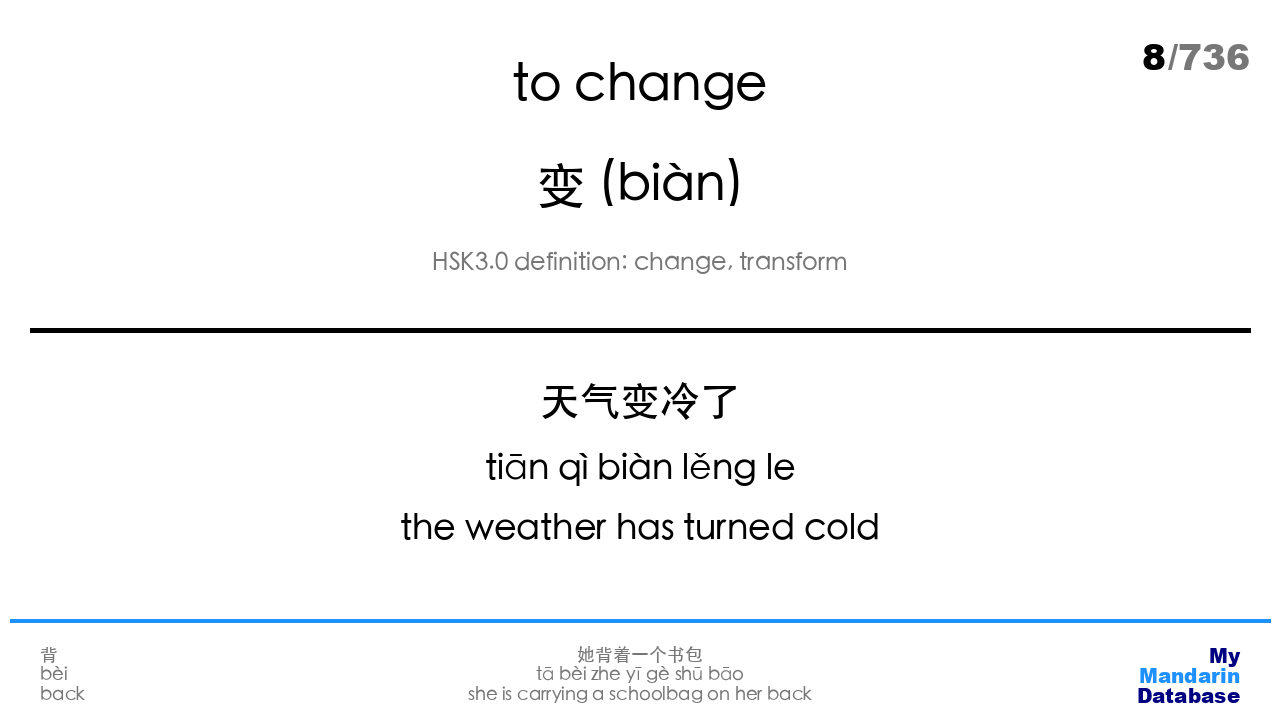

In [21]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides

In [ ]:
# # Extra add
# video_number=10
# output_path = 'output/videos/'
# hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# ####### Extra add above ##############################

# subtitle = {
#     'chinese': 'HSK2级音频卡片',
#     'pinyin': 'HSK2 jí yīnpín kǎpiàn',
#     'english': 'HSK2 audio flashcards'
#     }  # UPDATE ON NEW VIDEO
# nonvocab_slides = {
#     'intro': {
#         'chinese': f"欢迎观看我的普通话数据库视频 {video_number}: {subtitle['chinese']}",
#         'pinyin': f"Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpín {video_number}: {subtitle['pinyin']}",
#         'english': f"Welcome to my Mandarin Chinese Database Video {video_number}: {subtitle['english']}",
#         'clip_index': 0,
#         'change_index': -2,
#         'pause_ms': 500,

#         'channel_title': ('My Mandarin Database', '我的普通话数据库'),
#         'video_number': (f'Video #{video_number}', f'视频#{video_number}'),
#         'video_name': (subtitle['english'], subtitle['chinese']),
#         'video_structure': ('English first, Chinese second\nExample Chinese sentences', '先英文，后中文\n并附中文例句'),
#         'count_str': ("{n_vocab_words} words", "{n_vocab_words}个词汇"),
#         'duration_str': ('{audio_duration_minutes:.0f} minutes', '{audio_duration_minutes:.0f}分钟'),
#         'feedback': ('If you have any questions, suggestions, or feedback\nplease leave a comment', '如果你有任何问题、建议或反馈\n请留言'),

#         'x_bias_english_side': 80,
#         'text_configs': [
#             {
#             'font_name': hanzi_font_path,
#             'font_size': 32,
#             'y': 100,
#             'spacing': 20,
#             'align': 'center',
#             'fill': "#000000",
#             },
#             {
#             'font_name': hanzi_font_path,
#             'font_size': 24,
#             'y': 300,
#             'spacing': 10,
#             'align': 'center',
#             'fill': "#555555",
#             },
#             ]
#     },

#     'word_list': {
#         'chinese_unfill': '这些是将在接下来的{audio_duration_minutes:.0f}分钟内复习的{n_vocab}个单词',
#         'pinyin_unfill': 'Zhèxiē shì jiàng zài jiē xiàlái de {audio_duration_minutes:.0f} fēnzhōng nèi fùxí de {n_vocab} gè dāncí',
#         'english_unfill': 'These are the {n_vocab} words that will be reviewed over the next {audio_duration_minutes:.0f} minutes',
#         'clip_index': 1,
#         'change_index': -1,
#         'pause_ms': 500,

#         'y_top': 4,
#         'y_bottom': 80,
#         'x_top': 4,
#         'spacing': 1,
#         'font_size': 10,
#         'fill': '#000000',
#         'align': 'left',
#         'col_space': 1,
#         'col_space_big': 2,
#         'definition_configs':{
#             'chinese': {'x_offset': 0, 'x_max': 23, 'font_path': hanzi_font_path},
#             'pinyin': {'x_offset': None, 'x_max': 32, 'font_path': hanzi_font_path},
#             'english': {'x_offset': None, 'x_max': 39, 'font_path': hanzi_font_path},
#         },
#     },

#     'outro': {
#         'chinese': '如果你有任何问题、建议或反馈，请留言。请点赞并订阅。',
#         'pinyin': 'Rúguǒ nǐ yǒu rènhé wèntí, jiànyì huò fǎnkuì, qǐng liúyán. Qǐng diǎn zàn bìng dìngyuè.',
#         'english': 'If you have any questions, suggestions, or feedback, please leave a comment. Please like and subscribe.',
#         'clip_index': -1,
#         'change_index': None,
#         'pause_ms': 500,

#         'y_top': 4,
#         'y_bottom': 80,
#         'x_top': 4,
#         'spacing': 1,
#         'font_size': 10,
#         'fill': '#000000',
#         'align': 'left',
#         'col_space': 1,
#         'col_space_big': 2,
#         'definition_configs':{
#             'chinese': {'x_offset': 0, 'x_max': 23, 'font_path': hanzi_font_path},
#             'pinyin': {'x_offset': None, 'x_max': 32, 'font_path': hanzi_font_path},
#             'english': {'x_offset': None, 'x_max': 39, 'font_path': hanzi_font_path},
#         },
#     }
# }

# subtitle_text_configs = {
#     'font_size': 20,
#     'font_name': hanzi_font_path,
#     'y': 640,
#     'spacing': 5,
#     'align': 'center',
#     'fill': "#000000",
# }

# ####### Extra add ##############################
# subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])
# for nv_name, nv_settings in nonvocab_slides.items():
#     if 'chinese' not in nv_settings.keys():
#         nonvocab_slides[nv_name]['chinese'] = nv_settings['chinese_unfill'].format(**audio_filler_variables)
#         nonvocab_slides[nv_name]['pinyin'] = nv_settings['pinyin_unfill'].format(**audio_filler_variables)
#         nonvocab_slides[nv_name]['english'] = nv_settings['english_unfill'].format(**audio_filler_variables)
# for _, row in df_vocab_audio_durations.iterrows():
#     if not pd.isna(row['nonvocab_key']):
#         nonvocab_slides[row['nonvocab_key']]['duration'] = row['combined']
#         nonvocab_slides[row['nonvocab_key']]['start'] = row['start']


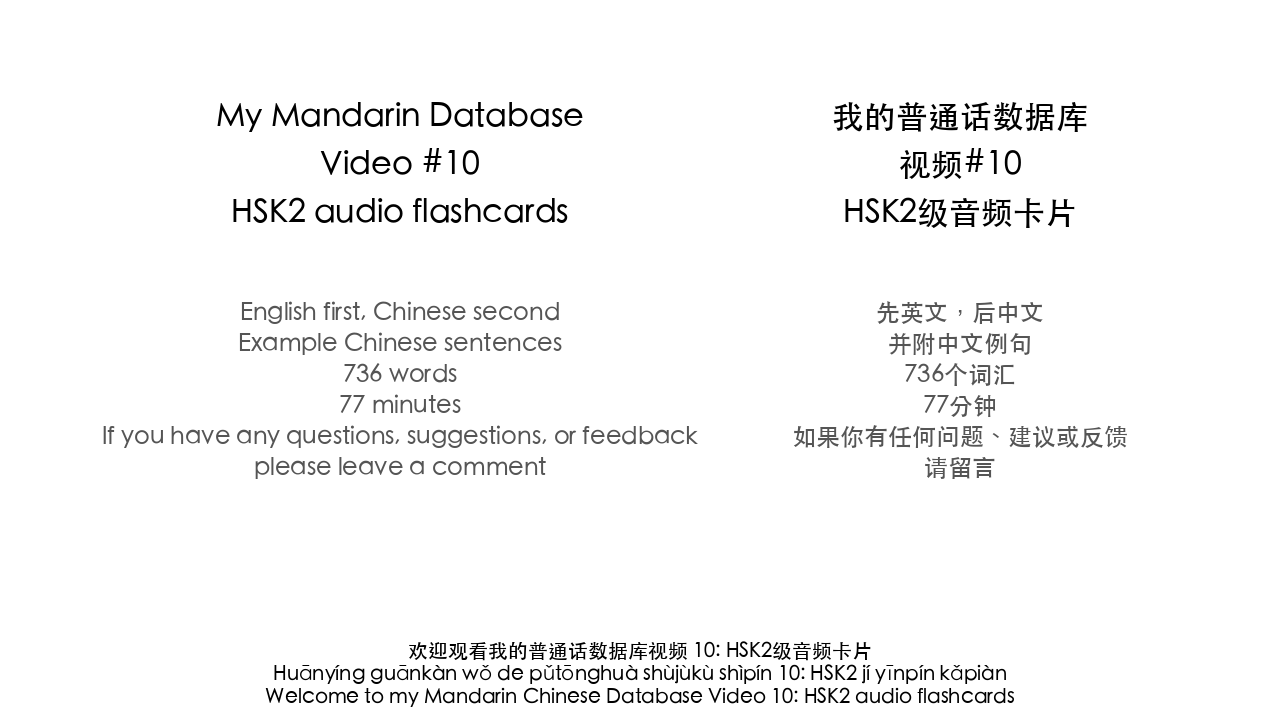

In [15]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

"to handle" reduced font size to 8
"bàn fǎ" reduced font size to 8
"bāng zhù" reduced font size to 8
"bāng zhù" reduced font size to 6
"bào míng" reduced font size to 8
"bào míng" reduced font size to 6
"to sign up" reduced font size to 8
"to change" reduced font size to 8
"to change" reduced font size to 6
"biàn chéng" reduced font size to 8
"biàn chéng" reduced font size to 6
"biàn chéng" reduced font size to 4
"to become" reduced font size to 8
"to become" reduced font size to 6
"bù yào" reduced font size to 8
"don’t want" reduced font size to 8
"don’t want" reduced font size to 6
"cān guān" reduced font size to 8
"cān guān" reduced font size to 6
"cān jiā" reduced font size to 8
"to participate" reduced font size to 8
"to participate" reduced font size to 6
"to participate" reduced font size to 4
"to check" reduced font size to 8
"to call/weigh" reduced font size to 8
"to call/weigh" reduced font size to 6
"chóng fù" reduced font size to 8
"chóng fù" reduced font size to 6
"to repe


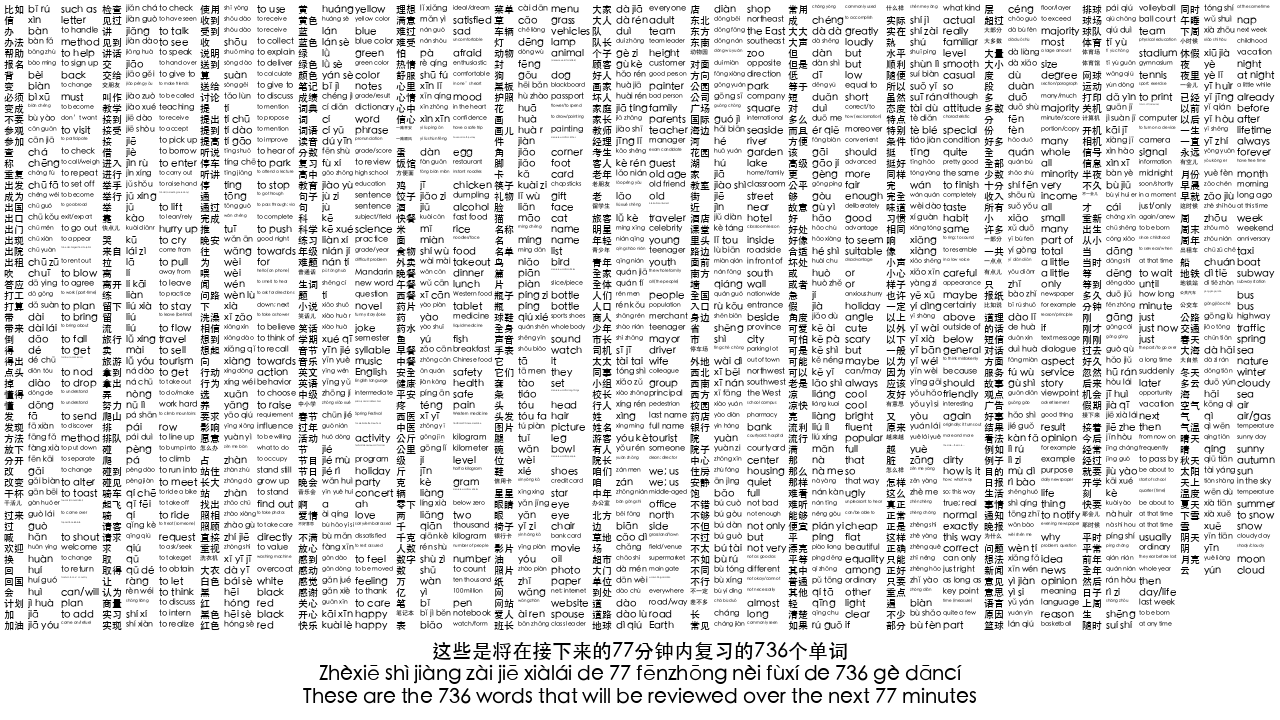

In [27]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

"to handle" reduced font size to 8
"bàn fǎ" reduced font size to 8
"bāng zhù" reduced font size to 8
"bāng zhù" reduced font size to 6
"bào míng" reduced font size to 8
"bào míng" reduced font size to 6
"to sign up" reduced font size to 8
"to change" reduced font size to 8
"to change" reduced font size to 6
"biàn chéng" reduced font size to 8
"biàn chéng" reduced font size to 6
"biàn chéng" reduced font size to 4
"to become" reduced font size to 8
"to become" reduced font size to 6
"bù yào" reduced font size to 8
"don’t want" reduced font size to 8
"don’t want" reduced font size to 6
"cān guān" reduced font size to 8
"cān guān" reduced font size to 6
"cān jiā" reduced font size to 8
"to participate" reduced font size to 8
"to participate" reduced font size to 6
"to participate" reduced font size to 4
"to check" reduced font size to 8
"to call/weigh" reduced font size to 8
"to call/weigh" reduced font size to 6
"chóng fù" reduced font size to 8
"chóng fù" reduced font size to 6
"to repe


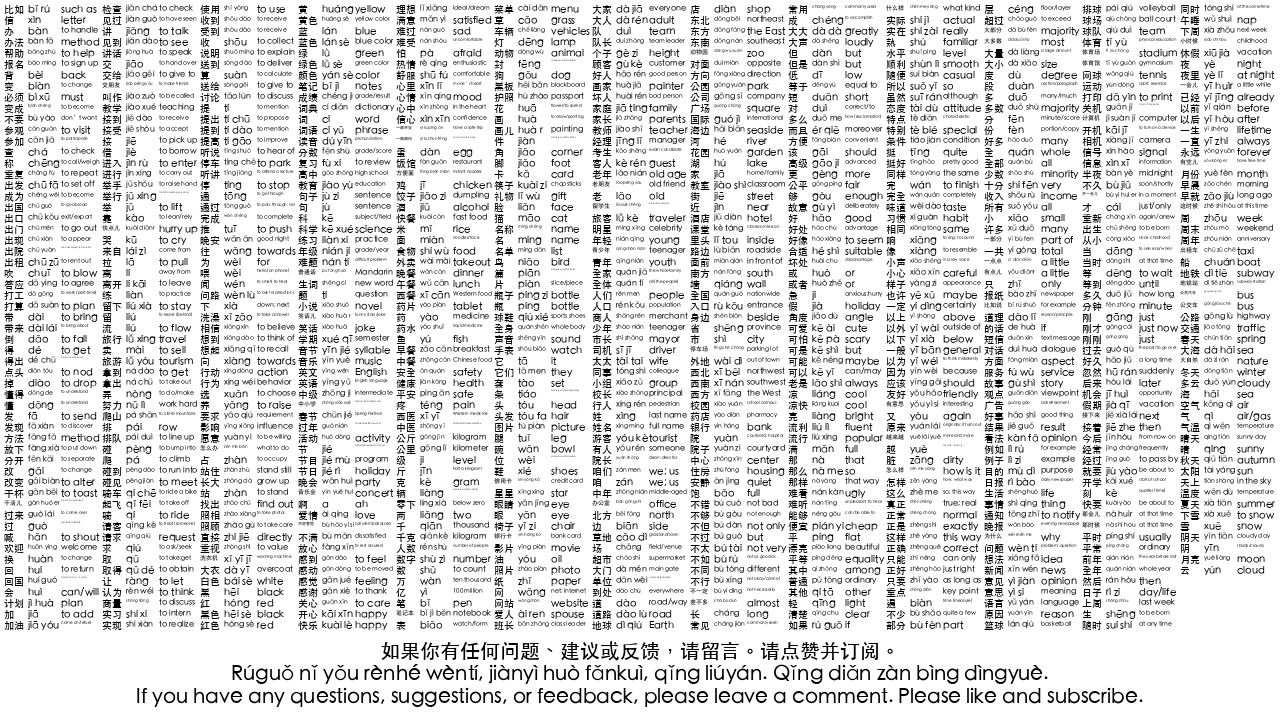

In [25]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


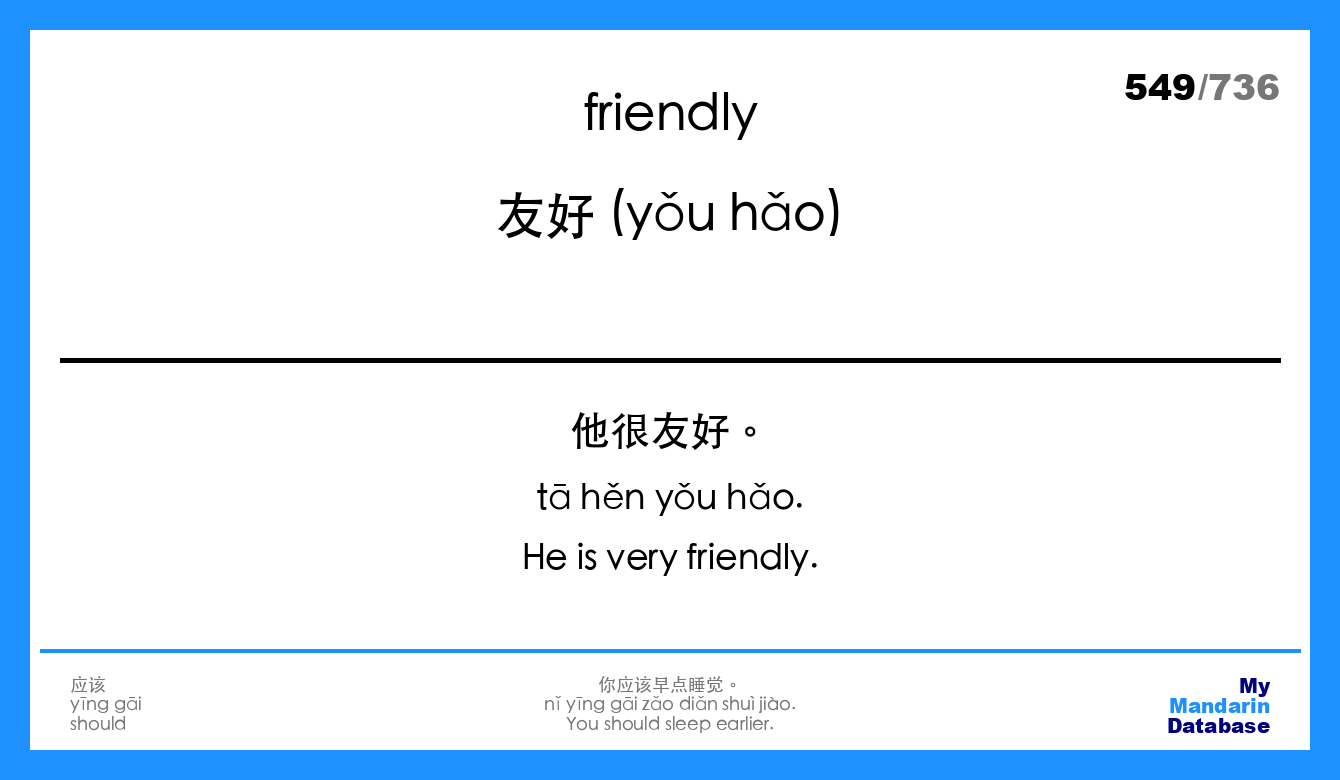

In [18]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()


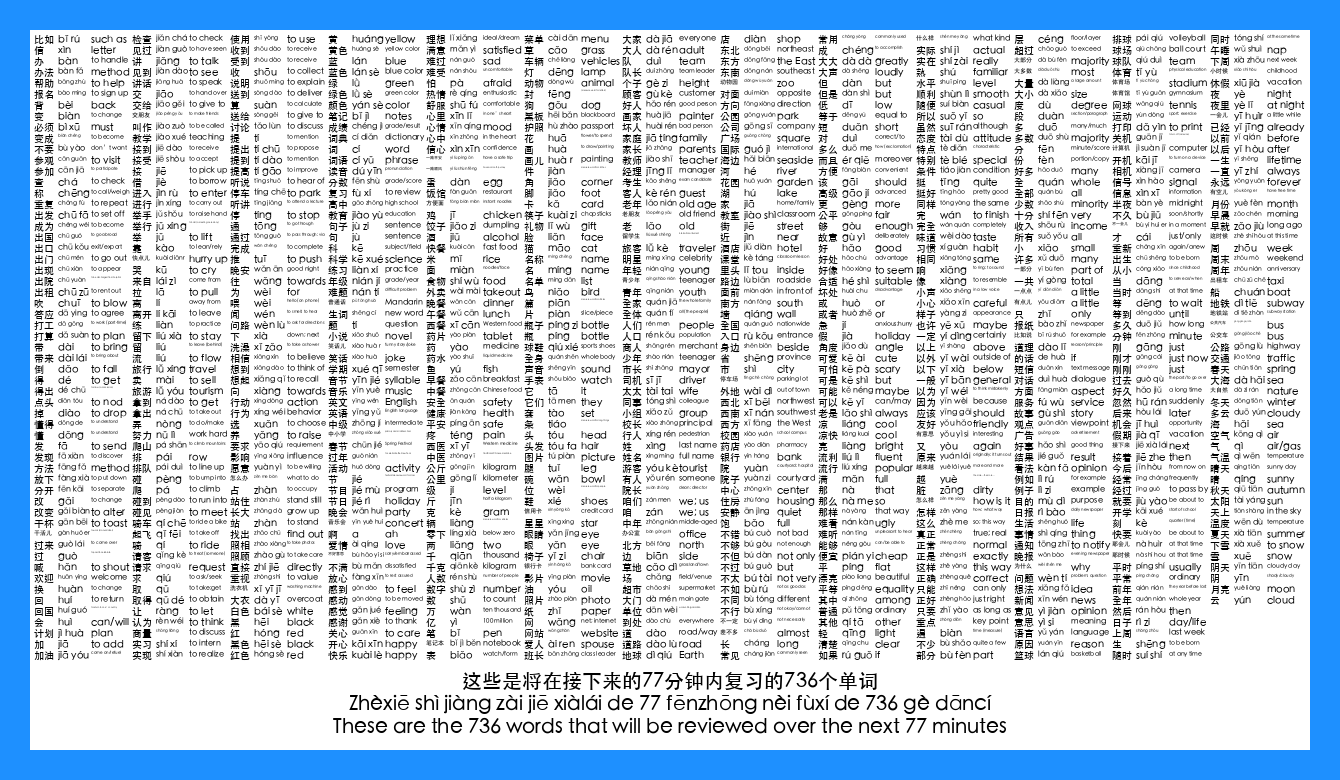

In [28]:
path_to_bottom_image = f"{project_artifacts_folder}/word_list.png"
img = create_icon_from_slide_general_path(icon_configs, video_configs, path_to_bottom_image)
img.save(f'{project_artifacts_folder}/icon2.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon2.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [29]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 2211
audio: 4614.410s, video: 4614.347s; difference: 0.063s
MoviePy - Building video output/videos/1001_ec_csent_hsk2_v1/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/1001_ec_csent_hsk2_v1/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/1001_ec_csent_hsk2_v1/video.mp4
